### Fig. 12
  

In [ ]:

import numpy as np
import pandas as pd
import sys, os
# sys.path.append('../src/')
sys.path.append('/home/caoyuyao/dataset_14T/UID-Moji/src') # --qg
from utils import get_hour_list, load_pressure_data, truncate_colormap, LandUse, \
    TcTools, if_in_china_index
from tqdm import tqdm
from datetime import datetime, timedelta
from quality_control import QualityControlTool
from interpolation import idw_interpolate_fastknn, idw_interpolate
import netCDF4 as nc
import matplotlib.pyplot as plt
from visualization import ObservationMap, ProbabilityMatrix
from scipy.io import netcdf
from interpolation import idw_interpolate_fastknn
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.gridspec as gridspec
import matplotlib
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib import font_manager 
font_path = "/mnt/cyy14/data_qg/old_draw/font"
font_files = font_manager.findSystemFonts(fontpaths=font_path)
for file in font_files:
    font_manager.fontManager.addfont(file)
plt.rcParams["font.sans-serif"] = "Arial"


        
def get_tc_location(tc_year, tc_name, hour_name):   
    # data_dir = '/media/cyy14T/TC_information/'
    data_dir = '/mnt/cyy14/TC_information/' # --qg
    tc_info_dict = np.load(data_dir+'STI-tc_info_dict_2016-2021.npy', allow_pickle = 'True').item()
    tc_info_list = tc_info_dict[(tc_year, tc_name.upper())]

    for i in range(len(tc_info_list)):
        tmp_hour_name = tc_info_list[i][0]
        tmp_lon = tc_info_list[i][1]
        tmp_lat = tc_info_list[i][2]
        tmp_pressure = tc_info_list[i][3]

        d1 = int((tmp_lat - 0)/0.5)
        d2 = int((tmp_lon - 70)/0.5)
        if d1<0 or d1>=110 or d2<0 or d2>=140 or if_in_china_index[d1, d2]==0:
            continue

        if tmp_hour_name == hour_name:
            return tmp_lon, tmp_lat, tmp_pressure
    


def load_hourly_sphn_data(tc_name = 'HAGUPIT', hour_name = '2019080405'):

    if tc_name.upper() == 'HAGUPIT':
        data_dir = '/mnt/cyy14/2020080400-2020080523_119.0-123.0_27.0-35.0_RF_MD9999_MSL1_N30_MS0.7_sea-level_low_elev_all_users_split_hourly_data/'
    elif tc_name.upper() == 'IN-FA':
        data_dir = '/mnt/cyy14/2021072500-2021073023_115.0-125.0_29.0-40.0_RF_MD9999_MSL1_N30_MS0.7_sea-level_low_elev_all_users_split_hourly_data/'
    elif tc_name.upper() == 'LEKIMA':
        data_dir = '/mnt/cyy14/2019080910-2019081110_117.2-123.2_27.3-33.3_RF_MD9999_MSL1_N30_MS0.7_sea-level_low_elev_all_users_split_hourly_data/'
    # --qg
    
    try:
        data = np.load(data_dir + hour_name + '_QCed_smartphone_data.npy')
        return data
    except FileNotFoundError:
        print('Wrong file name!')
        



def get_landmask(coord = 'c'):

    data_path = '/mnt/cyy14/WRF_Lake/met_em.d01.2021-06-30_06:00:00.nc' 
    ds = nc.Dataset(data_path)

    lon_c = ds.variables['XLONG_C'][0, :, :]
    lat_c = ds.variables['XLAT_C'][0, :, :]

    lon_m = ds.variables['XLONG_M'][0, :, :]
    lat_m = ds.variables['XLAT_M'][0, :, :]
    landmask = ds.variables['LANDMASK'][0, :, :]

    ds.close()

    if coord.upper() == 'C':
        return lon_c, lat_c, landmask
    else:
        return lon_m, lat_m, landmask
    


def add_landmask(obs_map, fill_type = 'contourf'):
    lon_c, lat_c, landmask = get_landmask()
    lon_m, lat_m, landmask = get_landmask('M')
    
    cmap = truncate_colormap(cmap = 'Blues_r', minval = 0.7, maxval = 1, n = 100)
    if fill_type == 'pcolormesh':
        obs_map.pcolormesh(lon_c, lat_c, landmask, cmap = cmap, colorbar = False, zorder = 1)
    else:
        obs_map.contourf(lon_m, lat_m, landmask, levels = [0, 1], cmap = cmap, colorbar = False)
    
    print(lon_m.shape)
    print(lat_m.shape)
    print(landmask.shape)


def get_tc_pressure_list(source = 'STI', tc_year = 2021, tc_name = 'IN-FA'):
    if tc_name.upper() == 'HAGUPIT':
        hour_list = ['2020080420', '2020080423', '2020080502']
    else:
        hour_list = get_hour_list('2021072605', '2021072923')[::3]

    data_dir = '/media/cyy14T/TC_information/'
    tc_info_dict = np.load(data_dir+source+'-tc_info_dict_2016-2021.npy', allow_pickle = 'True').item()
    tc_info_list = tc_info_dict[(tc_year, tc_name.upper())]

    tc_pressure_list = []
    for i in range(len(tc_info_list)):
        hour_name = str(tc_info_list[i][0])
        tc_pressure = tc_info_list[i][3]
        if hour_name not in hour_list:
            continue
        tc_pressure_list.append(tc_pressure)
        
    return tc_pressure_list


def get_cover_ratio(tc_lon, tc_lat, pressure_data, resolution = 0.1, box_size = 0.3):
    '''pressure_data: lon, lat, pressure. 3 columns'''
    cover_array = np.zeros((int(box_size*2/resolution), int(box_size*2/resolution)))
    for i in range(pressure_data.shape[0]):
        lon = pressure_data[i, 0]
        lat = pressure_data[i, 1]

        d1 = int((lat - tc_lat + box_size)/resolution)
        d2 = int((lon - tc_lon + box_size)/resolution)

        if d1<0 or d1>=cover_array.shape[0] or d2<0 or d2>=cover_array.shape[1]:
            continue  
        cover_array[d1, d2] = 1

    return np.sum(cover_array)/cover_array.size


def get_cover_ratio_list(resolution = 0.05, box_size = 0.3):
    hour_list = get_hour_list('2021072605', '2021072923')[::3]
    
    cover_ratio_list = []
    cover_ratio_dict = {}
    for hour_name in hour_list:
        data = load_hourly_sphn_data('IN-FA', hour_name)
        
        tc_lon, tc_lat, _ = get_tc_location(2021, 'IN-FA', hour_name)

        start_lon = tc_lon - box_size
        start_lat = tc_lat - box_size

        cover_grid = np.zeros((int(box_size*2/resolution), int(box_size*2/resolution)))
        for i in range(data.shape[0]):
            lon = data[i, 0]
            lat = data[i, 1]

            d1 = int((lat - start_lat)/resolution)
            d2 = int((lon - start_lon)/resolution)

            if d1<0 or d1>=cover_grid.shape[0] or d2<0 or d2>=cover_grid.shape[1]:
                continue  
            cover_grid[d1, d2] = 1
        
        cover_ratio = np.sum(cover_grid)/cover_grid.size
        cover_ratio_list.append(cover_ratio)

        cover_ratio_dict[hour_name] = cover_ratio

    return cover_ratio_list, cover_ratio_dict
            


def interquartile_check(data, radius = 0.5):
    '''
    data: 3 columns, lon, lat, pressure
    '''
    start_lat = int(np.nanmin(data[:, 1])*10)/10
    start_lon = int(np.nanmin(data[:, 0])*10)/10

    grid_sphn_dict = {}
    resolution = radius
    thld = 1
    for i in range(data.shape[0]):
        lon = data[i, 0]
        lat = data[i, 1]
        pressure = data[i, 2]

        d1 = int((lat - start_lat)/resolution)
        d2 = int((lon - start_lon)/resolution)
        grid_sphn_dict.setdefault((d1, d2), []).append([lon, lat, pressure])
    

    stacked_data = np.zeros((0, 3))
    for key in grid_sphn_dict:
        grid_sphn_dict[key] = np.array(grid_sphn_dict[key])
        perc_25 = np.nanpercentile(grid_sphn_dict[key][:, 2], 25)
        perc_75 = np.nanpercentile(grid_sphn_dict[key][:, 2], 75)
        inter_range = perc_75 - perc_25
        valid_ind = (grid_sphn_dict[key][:, 2] - perc_75<=thld*inter_range) & \
            (perc_25 - grid_sphn_dict[key][:, 2]<=thld*inter_range)
        
        valid_data = grid_sphn_dict[key][valid_ind]
        stacked_data = np.vstack((stacked_data, valid_data))
    return stacked_data


In [ ]:
sphn_data = load_hourly_sphn_data('LEKIMA', '2019081014')

(90115, 3)

In [ ]:

data_dir = '/mnt/cyy14/TC_information/' 
tc_info_dict = np.load(data_dir+'STI-tc_info_dict_2016-2021.npy', allow_pickle = 'True').item()
tc_info_list = tc_info_dict[(2021, 'IN-FA')]

flag = False
for i in range(len(tc_info_list)):
    tc_hour = tc_info_list[i][0]
    tc_lon = tc_info_list[i][1]
    tc_lat = tc_info_list[i][2]
    d1 = int((tc_lat - 0)/0.5)
    d2 = int((tc_lon - 70)/0.5)
    if if_in_china_index[d1][d2] == 1:
        flag = True
    
    if if_in_china_index[d1][d2] == 0 and flag:
        print(tc_info_list[i])
        break



['2021073002', 117.60000000000001, 38.5, 992.0, 15.0]


'台风烟花2021年7月26日5时登陆，7月29日23时为最后一个陆地上的点'

In [ ]:

hour_list = get_hour_list('2021072605', '2021072923')[::3]

station_cover_list = []
sphn_cover_list = []
min_sphn_list = []
bst_mslp_list = []

for hour_name in tqdm(hour_list):

    tc_lon, tc_lat, tc_pressure = get_tc_location(2021, 'IN-FA', hour_name)
    bst_mslp_list.append(tc_pressure)


    station_data = load_pressure_data(hour_name, True)
    radius = 0.6
    region_ind = (station_data[:, 1]>=tc_lon-radius) & (station_data[:, 1]<=tc_lon+radius) & (station_data[:, 2]>=tc_lat-radius) & (station_data[:, 2]<=tc_lat+radius)
    valid_ind = (~np.isnan(station_data[:, 4])) & (station_data[:, 3]<=50)
    station_data = station_data[region_ind&valid_ind, :]
    '''Interquartile check'''
    station_data = interquartile_check(station_data[:, np.array([1, 2, 4])], radius = 0.5)




    sphn_data = load_hourly_sphn_data('IN-FA', hour_name)
    region_ind = (sphn_data[:, 0]>=tc_lon-radius) & (sphn_data[:, 0]<=tc_lon+radius) & (sphn_data[:, 1]>=tc_lat-radius) & (sphn_data[:, 1]<=tc_lat+radius)
    sphn_data = sphn_data[region_ind]
    min_sphn_list.append(np.nanmin(sphn_data[:, 2]))

    


    station_cover = get_cover_ratio(tc_lon, tc_lat, station_data, resolution = 0.1, box_size = 0.3)
    sphn_cover = get_cover_ratio(tc_lon, tc_lat, sphn_data, resolution = 0.1, box_size = 0.3)
    if hour_name=='2021072705':
        st1=station_cover
        sp1=sphn_cover
        pr1=np.nanmin(sphn_data[:, 2])-tc_pressure

    station_cover_list.append(station_cover)
    sphn_cover_list.append(sphn_cover)



100%|███████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 54.75it/s]


In [ ]:

diff_list = np.array(min_sphn_list) - np.array(bst_mslp_list)
result_list = np.ones_like(diff_list)
result_list[diff_list<0] = 0
result_list[(diff_list>=0)&(diff_list<0.5)] = 1
result_list[(diff_list>=0.5)&(diff_list<1)] = 2
result_list[(diff_list>=1)&(diff_list<2)] = 3
result_list[(diff_list>=2)&(diff_list<4)] = 4
result_list[(diff_list>=4)] = 5

print(result_list.shape)

(31,)


In [ ]:
def plot_INFA_data(main = False, marker = 'o'):
    num_colors = 4
    cmap = plt.get_cmap('turbo', num_colors)

    global sphn_cover_list, station_cover_list, result_list, diff_list
    hour_list = get_hour_list('2021072605', '2021072923')[::3]

    sphn_cover_list = np.array(sphn_cover_list)
    station_cover_list = np.array(station_cover_list)

    plt.plot([-0.03, 1.02], [-0.03, 1.02], color = 'black', linestyle = '--', linewidth = 2)

    cover_pair_dict = {}
    for i in range(len(sphn_cover_list)):
        tmp_sphn_cover = sphn_cover_list[i]
        tmp_station_cover = station_cover_list[i]
        if (tmp_sphn_cover, tmp_station_cover) not in cover_pair_dict:
            cover_pair_dict[(tmp_sphn_cover, tmp_station_cover)] = 1
        else:
            sphn_cover_list[i] += 0.01
            station_cover_list[i] += 0.01

    plt.scatter(sphn_cover_list[result_list == 0], station_cover_list[result_list == 0], color = '#4f8fe4',\
                s = 60, label = '(, 0)', edgecolors = 'k', marker = marker)
    leg=plt.scatter(sphn_cover_list[result_list == 1], station_cover_list[result_list == 1], color = '#fdefdc',\
                    s = 60, label = '[0, 0.5)', edgecolors = 'k', marker = marker)
    plt.scatter(sphn_cover_list[result_list == 2], station_cover_list[result_list == 2], color = '#fbd2c0',\
                s = 60, label = '[0.5, 1)', edgecolors = 'k', marker = marker)
    plt.scatter(sphn_cover_list[result_list == 3], station_cover_list[result_list == 3], color = '#f89889',\
                s = 60, label = '[1, 2)', edgecolors = 'k', marker = marker)
    plt.scatter(sphn_cover_list[result_list == 4], station_cover_list[result_list == 4], color = '#db6256',\
                s = 60, label = '[2, 4)', edgecolors = 'k', marker = marker)
    plt.scatter(sphn_cover_list[result_list == 5], station_cover_list[result_list == 5], color = '#9f2a28',\
                s = 60, label = '[4, )', edgecolors = 'k', marker = marker)
    #plt.scatter([0.96], [0.08], marker = '+', color = 'k')
    plt.scatter([sp1], [st1], marker = '+', color = 'k', s=100)

    

    plt.xlim(0, 1.02)
    plt.ylim(0, 1.02)

    if main:
        plt.xlabel("Smartphone coverage ratio", fontsize = 15)
        plt.ylabel("Station coverage ratio", fontsize = 15)
        # plt.legend(loc = 'upper left', title = 'SPHN-BST (hPa)', ncol = 2)

        patch_0 = mpatches.Patch(color='#4f8fe4', label='(, 0)')
        patch_1 = mpatches.Patch(color='#fdefdc', label='[0, 0.5)')
        patch_2 = mpatches.Patch(color='#fbd2c0', label='[0.5, 1)')
        patch_3 = mpatches.Patch(color='#f89889', label='[1, 2)')
        patch_4 = mpatches.Patch(color='#db6256', label='[2, 4)')
        patch_5 = mpatches.Patch(color='#9f2a28', label='[4, )')

        l1=plt.legend(handles=[patch_0, patch_1, patch_2, patch_3, patch_4, patch_5], ncol=2,\
                      title = 'Smartphone-STI (hPa)')

    for i in range(len(hour_list)):
        hour_name = hour_list[i]
        if diff_list[i]<-0.5:
            print(hour_name)
            print(sphn_cover_list[i], station_cover_list[i])




        if sphn_cover_list[i] == 1 and station_cover_list[i] >0.75 and diff_list[i]<0:
            print('****', hour_name, '****', diff_list[i])

        if sphn_cover_list[i]<0.4 and station_cover_list[i] == 0:
            print('----', hour_name, '----', diff_list[i])
    return leg, l1



In [ ]:
'''HAGUPIT'''

hour_list = get_hour_list('2020080420', '2020080502')[::3]
print(hour_list)

station_cover_list_HGP = []
sphn_cover_list_HGP= []
min_sphn_list_HGP = []
bst_mslp_list_HGP = []

for hour_name in tqdm(hour_list):
    try:
        tc_lon, tc_lat, tc_pressure = get_tc_location(2020, 'HAGUPIT', hour_name)
        bst_mslp_list_HGP.append(tc_pressure)
    except TypeError: 
        # 不在陆地上
        continue


    station_data = load_pressure_data(hour_name, True)
    radius = 0.6
    region_ind = (station_data[:, 1]>=tc_lon-radius) & (station_data[:, 1]<=tc_lon+radius) & (station_data[:, 2]>=tc_lat-radius) & (station_data[:, 2]<=tc_lat+radius)
    valid_ind = (~np.isnan(station_data[:, 4])) & (station_data[:, 3]<=50)
    station_data = station_data[region_ind&valid_ind, :]
    '''Interquartile check'''
    station_data = interquartile_check(station_data[:, np.array([1, 2, 4])], radius = 0.5)



    sphn_data = load_hourly_sphn_data('HAGUPIT', hour_name)
    region_ind = (sphn_data[:, 0]>=tc_lon-radius) & (sphn_data[:, 0]<=tc_lon+radius) & (sphn_data[:, 1]>=tc_lat-radius) & (sphn_data[:, 1]<=tc_lat+radius)
    sphn_data = sphn_data[region_ind]
    min_sphn_list_HGP.append(np.nanmin(sphn_data[:, 2]))

    


    station_cover = get_cover_ratio(tc_lon, tc_lat, station_data, resolution = 0.1, box_size = 0.3)
    sphn_cover = get_cover_ratio(tc_lon, tc_lat, sphn_data, resolution = 0.1, box_size = 0.3)

    station_cover_list_HGP.append(station_cover)
    sphn_cover_list_HGP.append(sphn_cover)


diff_list_HGP = np.array(min_sphn_list_HGP) - np.array(bst_mslp_list_HGP)
result_list_HGP = np.ones_like(diff_list_HGP)
result_list_HGP[diff_list_HGP<0] = 0
result_list_HGP[(diff_list_HGP>=0)&(diff_list_HGP<0.5)] = 1
result_list_HGP[(diff_list_HGP>=0.5)&(diff_list_HGP<1)] = 2
result_list_HGP[(diff_list_HGP>=1)&(diff_list_HGP<2)] = 3
result_list_HGP[(diff_list_HGP>=2)&(diff_list_HGP<4)] = 4
result_list_HGP[(diff_list_HGP>=4)] = 5

print(result_list.shape)


['2020080420', '2020080423', '2020080502']


100%|█████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 53.53it/s]

(31,)


In [ ]:
def plot_HAGUPIT_data(main = False, marker = 'o'):
    num_colors = 4
    cmap = plt.get_cmap('turbo', num_colors)

    global sphn_cover_list_HGP, station_cover_list_HGP, result_list_HGP
    sphn_cover_list_HGP = np.array(sphn_cover_list_HGP)
    station_cover_list_HGP = np.array(station_cover_list_HGP)

    plt.plot([-0.03, 1.02], [-0.03, 1.02], color = 'black', linestyle = '--', linewidth = 2)

    cover_pair_dict = {}
    for i in range(len(sphn_cover_list_HGP)):
        tmp_sphn_cover = sphn_cover_list_HGP[i]
        tmp_station_cover = station_cover_list_HGP[i]
        if (tmp_sphn_cover, tmp_station_cover) not in cover_pair_dict:
            cover_pair_dict[(tmp_sphn_cover, tmp_station_cover)] = 1
        else:
            sphn_cover_list_HGP[i] += 0.01
            station_cover_list_HGP[i] += 0.01

    plt.scatter(sphn_cover_list_HGP[result_list_HGP == 0], station_cover_list_HGP[result_list_HGP == 0], color = '#4f8fe4', s = 60, label = '(, 0)',\
                edgecolors = 'k', marker = marker)
    leg=plt.scatter(sphn_cover_list_HGP[result_list_HGP == 1], station_cover_list_HGP[result_list_HGP == 1], color = '#fdefdc', s = 60, label = '[0, 0.5)', edgecolors = 'k', marker = marker)
    plt.scatter(sphn_cover_list_HGP[result_list_HGP == 2], station_cover_list_HGP[result_list_HGP == 2], color = '#fbd2c0', s = 60, label = '[0.5, 1)', edgecolors = 'k', marker = marker)
    plt.scatter(sphn_cover_list_HGP[result_list_HGP == 3], station_cover_list_HGP[result_list_HGP == 3], color = '#f89889', s = 60, label = '[1, 2)', edgecolors = 'k', marker = marker)
    plt.scatter(sphn_cover_list_HGP[result_list_HGP == 4], station_cover_list_HGP[result_list_HGP == 4], color = '#db6256', s = 60, label = '[2, 4)', edgecolors = 'k', marker = marker)
    plt.scatter(sphn_cover_list_HGP[result_list_HGP == 5], station_cover_list_HGP[result_list_HGP == 5], color = '#9f2a28', s = 60, label = '[4, )', edgecolors = 'k', marker = marker)
    #plt.scatter([0.88], [0.16], marker = '+')

    plt.xlim(0, 1.02)
    plt.ylim(0, 1.02)

    if main:
        plt.xlabel("Smartphone coverage ratio", fontsize = 12)
        plt.ylabel("Station coverage ratio", fontsize = 12)
        plt.legend(loc = 'upper left', title = 'SPHN-BST (hPa)', ncol = 2)
    
    return leg




In [ ]:

data_dir = '/mnt/cyy14/TC_information/' 
tc_info_dict = np.load(data_dir+'STI-tc_info_dict_2016-2021.npy', allow_pickle = 'True').item()
tc_info_list = tc_info_dict[(2019, 'LEKIMA')]

flag = False
for i in range(len(tc_info_list)):
    tc_hour = tc_info_list[i][0]
    tc_lon = tc_info_list[i][1]
    tc_lat = tc_info_list[i][2]

    if tc_lon>=117.2 and tc_lon<=123.2 and tc_lat>=27.3 and tc_lat<=33.3:
        if not flag:
            print(tc_hour)
        flag = True
    
    if not (tc_lon>=117.2 and tc_lon<=123.2 and tc_lat>=27.3 and tc_lat<=33.3) and flag:
        print(tc_hour)
        break

2019080917
2019081108


In [ ]:
'''LEKIMA'''
#hour_list = get_hour_list('2019080917', '2019081108')[::3]
hour_list = get_hour_list('2019081014', '2019081105')[::3]
print(hour_list)

station_cover_list_LKM = []
sphn_cover_list_LKM= []
min_sphn_list_LKM = []
bst_mslp_list_LKM = []

for hour_name in tqdm(hour_list):

    try:
        tc_lon, tc_lat, tc_pressure = get_tc_location(2019, 'LEKIMA', hour_name)
    except TypeError: 
        # 不在陆地上
        continue

    if tc_lon<117.2-0.3 or tc_lon>123.2+0.3 or tc_lat<27.3-0.3 or tc_lat>33.3+0.3:
        continue


    radius = 0.6
    try:
        sphn_data = load_hourly_sphn_data('LEKIMA', hour_name)
        region_ind = (sphn_data[:, 0]>=tc_lon-radius) & (sphn_data[:, 0]<=tc_lon+radius) & (sphn_data[:, 1]>=tc_lat-radius) & (sphn_data[:, 1]<=tc_lat+radius)
        sphn_data = sphn_data[region_ind]
        min_sphn_list.append(np.nanmin(sphn_data[:, 2]))

        min_sphn_list_LKM.append(np.nanmin(sphn_data[:, 2]))
        bst_mslp_list_LKM.append(tc_pressure)
    except TypeError:
        continue


    station_data = load_pressure_data(hour_name, True)
    radius = 0.6
    region_ind = (station_data[:, 1]>=tc_lon-radius) & (station_data[:, 1]<=tc_lon+radius) & (station_data[:, 2]>=tc_lat-radius) & (station_data[:, 2]<=tc_lat+radius)
    valid_ind = (~np.isnan(station_data[:, 4])) & (station_data[:, 3]<=50)
    station_data = station_data[region_ind&valid_ind, :]
    '''Interquartile check'''
    station_data = interquartile_check(station_data[:, np.array([1, 2, 4])], radius = 0.5)

    
    

    station_cover = get_cover_ratio(tc_lon, tc_lat, station_data, resolution = 0.1, box_size = 0.3)
    sphn_cover = get_cover_ratio(tc_lon, tc_lat, sphn_data, resolution = 0.1, box_size = 0.3)
    if hour_name=='2019081023':
        st2=station_cover
        sp2=sphn_cover
        pr2=np.nanmin(sphn_data[:, 2])-tc_pressure

    station_cover_list_LKM.append(station_cover)
    sphn_cover_list_LKM.append(sphn_cover)




diff_list_LKM = np.array(min_sphn_list_LKM) - np.array(bst_mslp_list_LKM)
result_list_LKM = np.ones_like(diff_list_LKM)
result_list_LKM[diff_list_LKM<0] = 0
result_list_LKM[(diff_list_LKM>=0)&(diff_list_LKM<0.5)] = 1
result_list_LKM[(diff_list_LKM>=0.5)&(diff_list_LKM<1)] = 2
result_list_LKM[(diff_list_LKM>=1)&(diff_list_LKM<2)] = 3
result_list_LKM[(diff_list_LKM>=2)&(diff_list_LKM<4)] = 4
result_list_LKM[(diff_list_LKM>=4)] = 5

print(result_list_LKM.shape)


['2019081014', '2019081017', '2019081020', '2019081023', '2019081102', '2019081105']


100%|█████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 47.69it/s]

(6,)


In [ ]:
def plot_LEKIMA_data(main = False, marker = 'o'):
    num_colors = 4
    cmap = plt.get_cmap('turbo', num_colors)
    
    global sphn_cover_list_LKM, station_cover_list_LKM, result_list_LKM
    sphn_cover_list_LKM = np.array(sphn_cover_list_LKM)
    station_cover_list_LKM = np.array(station_cover_list_LKM)

    plt.plot([-0.03, 1.02], [-0.03, 1.02], color = 'black', linestyle = '--', linewidth = 2)

    cover_pair_dict = {}
    for i in range(len(sphn_cover_list_LKM)):
        tmp_sphn_cover = sphn_cover_list_LKM[i]
        tmp_station_cover = station_cover_list_LKM[i]
        if (tmp_sphn_cover, tmp_station_cover) not in cover_pair_dict:
            cover_pair_dict[(tmp_sphn_cover, tmp_station_cover)] = 1
        else:
            sphn_cover_list_LKM[i] += 0.01
            station_cover_list_LKM[i] += 0.01

    plt.scatter(sphn_cover_list_LKM[result_list_LKM == 0], station_cover_list_LKM[result_list_LKM == 0],\
                color = '#4f8fe4', s = 60, label = '(, 0)', edgecolors = 'k', marker = marker)
    leg=plt.scatter(sphn_cover_list_LKM[result_list_LKM == 1], station_cover_list_LKM[result_list_LKM == 1],\
                    color = '#fdefdc', s = 60, label = '[0, 0.5)', edgecolors = 'k', marker = marker)
    plt.scatter(sphn_cover_list_LKM[result_list_LKM == 2], station_cover_list_LKM[result_list_LKM == 2],\
                color = '#fbd2c0', s = 60, label = '[0.5, 1)', edgecolors = 'k', marker = marker)
    plt.scatter(sphn_cover_list_LKM[result_list_LKM == 3], station_cover_list_LKM[result_list_LKM == 3],\
                color = '#f89889', s = 60, label = '[1, 2)', edgecolors = 'k', marker = marker)
    plt.scatter(sphn_cover_list_LKM[result_list_LKM == 4], station_cover_list_LKM[result_list_LKM == 4],\
                color = '#db6256', s = 60, label = '[2, 4)', edgecolors = 'k', marker = marker)
    plt.scatter(sphn_cover_list_LKM[result_list_LKM == 5], station_cover_list_LKM[result_list_LKM == 5],\
                color = '#9f2a28', s = 60, label = '[4, )', edgecolors = 'k', marker = marker)
    plt.scatter([sp2], [st2], marker = '+', color = 'k', s=100)


    plt.xlim(0, 1.02)
    plt.ylim(0, 1.02)

    if main:
        plt.xlabel("Smartphone coverage ratio", fontsize = 15)
        plt.ylabel("Station coverage ratio", fontsize = 15)
        plt.legend(loc = 'upper left', title = 'SPHN-BST (hPa)', ncol = 2)
    
    return leg



In [11]:
diff_hist=np.append(diff_list, diff_list_HGP, axis=0)
diff_hist=np.append(diff_hist, diff_list_LKM, axis=0)
diff_hist[diff_hist>5]=4.999999
print(diff_hist)

[ 2.60430908e+00  1.61547852e+00  1.06616211e+00  2.76263428e+00
  2.79785156e+00  4.03448486e+00  3.91845703e-01 -1.39312744e+00
 -1.60681152e+00 -3.78417969e-02  1.37115479e+00 -1.92871094e-02
  1.63085938e-01  4.37438965e-01 -1.75720215e-01  4.83520508e-01
  7.22839355e-01  4.27246094e-04  1.25421143e+00 -7.39196777e-01
 -4.19372559e-01  1.62219238e+00  8.10546875e-02 -1.07116699e-01
  5.46081543e-01 -2.11669922e-01  2.80273438e-01  1.32177734e+00
  1.09521484e+00 -3.73657227e-01  1.46667480e-01  2.75793457e+00
  1.05523682e+00  1.06115723e+00  2.75695801e+00  2.95043945e-01
 -7.65441895e-01  2.09802246e+00  1.58142090e+00  1.98345947e+00]


In [ ]:

high=0
low=0
for i in range(len(sphn_cover_list_LKM)):
    if sphn_cover_list_LKM[i]>station_cover_list_LKM[i]:
        high+=1
    else:
        low+=1
for i in range(len(sphn_cover_list_HGP)):
    if sphn_cover_list_HGP[i]>station_cover_list_HGP[i]:
        high+=1
    else:
        low+=1
for i in range(len(sphn_cover_list)):
    if sphn_cover_list[i]>station_cover_list[i]:
        high+=1
    else:
        low+=1
print(high)
print(low)

39
1


2021072702
0.4 0.48
2021072705
0.88 0.16
**** 2021072723 **** -0.17572021484375
2021072814
0.92 0.08
---- 2021072917 ---- 1.09521484375
mean
0.8134674072265625


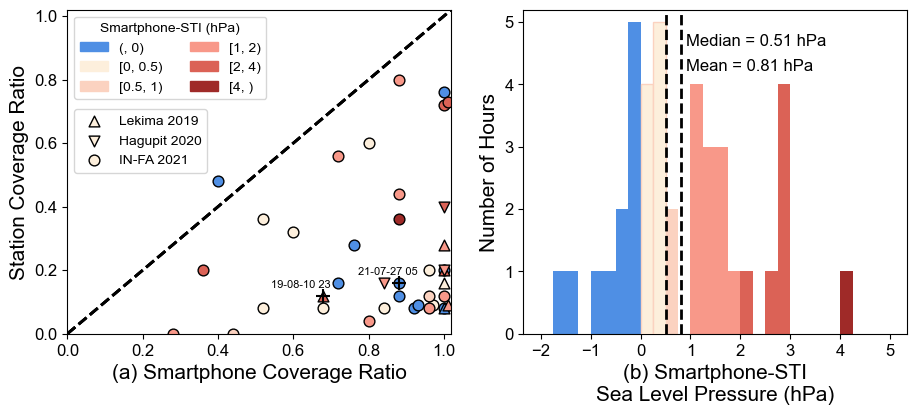

In [ ]:
fig=plt.figure(1)
fig.set_size_inches(12, 12)


mx=0.15
x0=0.32
y0=0.27

color_list=['#4f8fe4','#fdefdc', '#fbd2c0', '#f89889', '#db6256', '#9f2a28']


# a
ax=plt.axes([mx, 0.5-y0/2, x0, y0])
plt.sca(ax)

s1, l1=plot_INFA_data(1, marker = 'o')
s2=plot_LEKIMA_data(0, marker = '^')
s3=plot_HAGUPIT_data(0, marker = 'v')
plt.legend([s2, s3, s1],['Lekima 2019', 'Hagupit 2020', 'IN-FA 2021'], loc='center left',\
           bbox_to_anchor=(0,0.595))
plt.gca().add_artist(l1)
plt.xlabel('(a) Smartphone Coverage Ratio', fontsize=15)
plt.ylabel('Station Coverage Ratio', fontsize=15)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize = 12)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize = 12)
plt.text(sp1-0.03, st1+0.02, s = '21-07-27 05', fontsize=8, verticalalignment="bottom", horizontalalignment="center")
plt.text(sp2+0.02, st2+0.02, s = '19-08-10 23', fontsize=8, verticalalignment="bottom", horizontalalignment="right")


# b
ax=plt.axes([1-mx-x0, 0.5-y0/2, x0, y0])
plt.sca(ax)
plt.hist(diff_hist[diff_hist<0], bins=np.arange(-2, 0.1, 0.25), facecolor=color_list[0])
plt.hist(diff_hist[(diff_hist>=0)&(diff_hist<0.5)], bins=np.arange(0, 0.6, 0.25), facecolor=color_list[1],\
         edgecolor=color_list[2], zorder=999)
plt.hist(diff_hist[(diff_hist>=0.5)&(diff_hist<1)], bins=np.arange(0.5, 1.1, 0.25), facecolor=color_list[2])
plt.hist(diff_hist[(diff_hist>=1)&(diff_hist<2)], bins=np.arange(1, 2.1, 0.25), facecolor=color_list[3])
plt.hist(diff_hist[(diff_hist>=2)&(diff_hist<4)], bins=np.arange(2, 4.1, 0.25), facecolor=color_list[4])
plt.hist(diff_hist[diff_hist>=4], bins=np.arange(4, 5.1, 0.25), facecolor=color_list[5])

med=np.median(diff_hist)
mea=np.mean(diff_hist)
print('mean')
print(mea)
plt.plot([med, med], [0, 5.3], color = 'black', linestyle = '--', linewidth = 2, zorder=999)
plt.plot([mea, mea], [0, 5.3], color = 'black', linestyle = '--', linewidth = 2, zorder=999)
plt.text(mea+0.1, 4.7, s = 'Median = {:.2f} hPa'.format(med), fontsize=12, verticalalignment="center", horizontalalignment="left")
plt.text(mea+0.1, 4.3, s = 'Mean = {:.2f} hPa'.format(mea), fontsize=12, verticalalignment="center", horizontalalignment="left")

plt.xlabel('(b) Smartphone-STI\nSea Level Pressure (hPa)', fontsize=15)
plt.ylabel('Number of Hours', fontsize=15)
plt.yticks(list(range(0, 6)), fontsize = 12)
plt.xticks(list(range(-2,6)), fontsize = 12)
plt.ylim([0, 5.2])

fig_dir = '/mnt/cyy14/data_qg/old_draw/submit/'
plt.savefig(fig_dir + 'f11.pdf', dpi = 300, format='pdf', bbox_inches = 'tight')
